In [25]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr
from sklearn.neighbors import NearestCentroid as NCC
from sklearn.linear_model import LogisticRegression

In [2]:
def filter(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

In [3]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

eog_channel = 'EOG' 

all_channels = eeg_channels + [eog_channel]
all_labels = pd.read_csv('TrainLabels.csv').Prediction.values

try:
    all_epochs = np.load('all_epochs.npy')
except:
    all_epochs = [] # Store cleaned EEG epochs

    # --- Loop through sessions ---
    for filename in tqdm(os.listdir('train')):
        session_data = pd.read_csv(os.path.join('train', filename))

        # --- 1. Filter EEG and EOG Channels ---
        print(f"\nProcessing {filename}...")
        for id in all_channels:
            session_data[id] = filter(session_data[id].values)

        # --- 2. Prepare Continuous Data for ICA ---
        # Shape: (n_channels, n_timepoints)
        eeg_data = session_data[eeg_channels].values.T
        eog_data = session_data[eog_channel].values.reshape(1, -1) # Keep as 2D array

        # Transpose for sklearn: (n_timepoints, n_features)
        eeg_data_skl = eeg_data.T
        eog_data_skl = eog_data.T

        # --- 3. Standardize Data ---
        scaler_eeg = StandardScaler()
        eeg_data_scaled = scaler_eeg.fit_transform(eeg_data_skl)

        scaler_eog = StandardScaler()
        eog_data_scaled = scaler_eog.fit_transform(eog_data_skl) # Scale EOG separately

        # --- 4. Fit ICA on EEG Data ---
        n_components_ica = len(eeg_channels) # Use number of EEG channels as components
        ica = FastICA(n_components=n_components_ica,
                        random_state=42,
                        whiten='unit-variance', # Recommended for FastICA
                        max_iter=1000, # Increase iterations if convergence is an issue
                        tol=0.001)     # Convergence tolerance

        print("Fitting ICA...")
        sources_eeg = ica.fit_transform(eeg_data_scaled) # Shape: (n_timepoints, n_components_ica)
        print("ICA fitting complete.")

        # --- 5. Identify EOG Component(s) via Correlation ---
        print("Identifying EOG components...")
        correlations = []
        eog_signal_flat = eog_data_scaled.flatten() # Ensure EOG is 1D for correlation

        for i in range(sources_eeg.shape[1]):
            component_signal = sources_eeg[:, i]
            # Calculate Pearson correlation coefficient and p-value
            corr, _ = pearsonr(eog_signal_flat, component_signal)
            correlations.append(abs(corr)) # Use absolute correlation

            eog_component_index = np.argmax(correlations)
            max_corr = correlations[eog_component_index]

            print(f"Removing component {eog_component_index} with correlation: {max_corr:.4f}")
            sources_cleaned = sources_eeg.copy()
            sources_cleaned[:, eog_component_index] = 0

        # --- 7. Reconstruct Cleaned EEG Data ---
        print("Reconstructing cleaned EEG data...")
        # Use inverse_transform to go from sources back to sensor space
        eeg_data_cleaned_scaled = ica.inverse_transform(sources_cleaned)

        # --- 8. Un-standardize Cleaned EEG Data ---
        eeg_data_cleaned_unscaled = scaler_eeg.inverse_transform(eeg_data_cleaned_scaled)

        # Prepare cleaned data for epoching (back to DataFrame structure)
        eeg_data_to_epoch = pd.DataFrame(eeg_data_cleaned_unscaled, columns=eeg_channels, index=session_data.index)
        print("EEG data cleaned.")


        # --- 9. Epoching
        session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
        session_epochs = []
        print(f"Epoching {len(session_feedback_ids)} events...")
        for idx in session_feedback_ids:
            # Define epoch window relative to event index
            start_idx = idx - 40  # 200ms before (40 samples at 200Hz)
            end_idx = idx + 199 # 1000ms after (200 samples at 200Hz) -> inclusive index for .loc

            # Define baseline window relative to event index
            baseline_start_idx = idx - 40 # 200ms before
            baseline_end_idx = idx      # Up to (but not including) the event

            # Extract epoch data for EEG channels
            epoch_data = eeg_data_to_epoch.loc[start_idx:end_idx].copy()

            # Calculate baseline using the correct window from the *epoched* data
            baseline_data = epoch_data.loc[baseline_start_idx:baseline_end_idx]
            baseline_mean = baseline_data.mean(axis=0)

            # Apply baseline correction
            epoch_data -= baseline_mean

            # Append the baseline-corrected epoch (EEG channels only)
            session_epochs.append(epoch_data.values) # Append numpy array

        all_epochs.extend(session_epochs) # Add the cleaned epochs to the list
        print(f"Finished {filename}. Total epochs collected: {len(all_epochs)}")


    # --- Convert cleaned epochs to NumPy array ---
    # Shape: (n_epochs, n_timepoints_in_epoch, n_eeg_channels)
    all_epochs = np.array(all_epochs)
    print(f"Final shape of cleaned epochs array: {all_epochs.shape}")

In [4]:
epochs_train, epochs_test, y_train, y_test = train_test_split(all_epochs, all_labels, test_size=0.2, random_state=42)

# All time points

In [5]:
def build_dataset(epochs, channels, t_start, t_end, window_size):
    time_points = range((t_start + 200) // 5, (t_end + 200) // 5, window_size)
    X = []
    for id in tqdm(range(len(channels))):
        channel_data = [epoch[:, id] for epoch in epochs]  # shape: (n_epochs, n_timepoints)
        channel_data = np.array(channel_data)  # shape: (n_epochs, 240)

        for time_point in time_points:  # all time points from -200 to 1000 ms
            time_point_data = channel_data[:, time_point:time_point+window_size].mean(axis=1)  # shape: (n_epochs,)
            X.append(time_point_data)

    X = np.array(X).T  # shape: (n_samples, n_features)
    return X

In [6]:
def preprocess(X_train, X_test, apply_pca, n_components):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if not apply_pca:
        print("No PCA applied")
        return X_train_scaled, X_test_scaled
    
    pca = PCA(n_components)  # This will retain enough components to explain 95% of the variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"Applying PCA ({n_components if n_components else 1} variance, {pca.n_components_} components)")
    return X_train_pca, X_test_pca

In [ ]:
def fit_models(X_train, X_test, y_train, y_test, apply_pca=False, n_components=0.95):
    X_train_pca, X_test_pca = preprocess(X_train, X_test, apply_pca, n_components)
    models = {"NCC": NCC(), "LDA": LDA(priors=[0.5, 0.5]), "RLDA": LDA(solver='lsqr', shrinkage="auto", priors=[0.5, 0.5]), "Logistic": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')}
    for name in models.keys():
        model = models[name]
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        print(f"    {name}: {f1_score(y_test, y_pred, average='macro'):.4f}")

In [29]:
def loop(X_train, X_test, y_train, y_test, try_no_pca=True):
    seqs = [(True, 0.95), (True, 0.99), (True, None)]
    if try_no_pca:
        seqs = [(False, None)] + seqs
    for apply_pca, n_components in seqs:
        fit_models(X_train, X_test, y_train, y_test, apply_pca=apply_pca, n_components=n_components)
        print()

In [9]:
X_train = build_dataset(epochs_train, eeg_channels, -200, 1000, 1)
X_test = build_dataset(epochs_test, eeg_channels, -200, 1000, 1)

100%|██████████| 56/56 [00:00<00:00, 313.33it/s]


In [10]:
loop(X_train, X_test, y_train, y_test, try_no_pca=False)

Applying PCA (0.95 variance, 287 components)
    NCC: 0.5695
    LDA: 0.5692
    RLDA: 0.5414

Applying PCA (0.99 variance, 1079 components)
    NCC: 0.5690
    LDA: 0.6093
    RLDA: 0.5759

Applying PCA (1 variance, 4352 components)
    NCC: 0.5690
    LDA: 0.4963
    RLDA: 0.5196



# Interval

In [9]:
def roc_dict(epochs, channels, t_start, t_end, window_size):
    time_points = range((t_start + 200) // 5, (t_end + 200) // 5, window_size)
    channel_to_roc = {}
    for id, channel in tqdm(enumerate(channels)):
        channel_data = [epoch[:, id] for epoch in epochs]  # shape: (n_epochs, n_timepoints)
        channel_data = np.array(channel_data)  # shape: (n_epochs, 240)
        rocs = []
        for time_point in time_points:  # all time points from -200 to 1000 ms
            time_point_data = channel_data[:, time_point:time_point+window_size].mean(axis=1)  # shape: (n_epochs,)
            roc = roc_auc_score(y_train, time_point_data)  # Calculate AUC for this time point
            rocs.append(roc)
        channel_to_roc[channel] = rocs
    return channel_to_roc

In [10]:
def plot_roc(epochs, channels, t_start, t_end, window_size):
    channel_to_roc = roc_dict(epochs, channels, t_start, t_end, window_size)
    # Step 3: Plot the ROC-AUC heatmap for training data
    arr = np.array(list(channel_to_roc.values()))
    # Generate time labels from -200 ms to 1000 ms, rounded to integers
    #time_labels = np.linspace(-200, 1000, arr.shape[1]).astype(int)

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(arr, cmap='jet', vmin=0.35, vmax=0.65)

    plt.yticks(np.arange(0, len(channels)), channels, rotation=0)

    
    print(f"Time points: {np.linspace(t_start, t_end, 100).astype(int)}")
    # Labeling the axes and title
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    plt.title('ROC AUC for each channel over time (Training Data)')

    # Display the plot
    plt.show()

56it [00:16,  3.47it/s]


Time points: [-200 -187 -175 -163 -151 -139 -127 -115 -103  -90  -78  -66  -54  -42
  -30  -18   -6    6   18   30   42   54   66   78   90  103  115  127
  139  151  163  175  187  200  212  224  236  248  260  272  284  296
  309  321  333  345  357  369  381  393  406  418  430  442  454  466
  478  490  503  515  527  539  551  563  575  587  600  612  624  636
  648  660  672  684  696  709  721  733  745  757  769  781  793  806
  818  830  842  854  866  878  890  903  915  927  939  951  963  975
  987 1000]


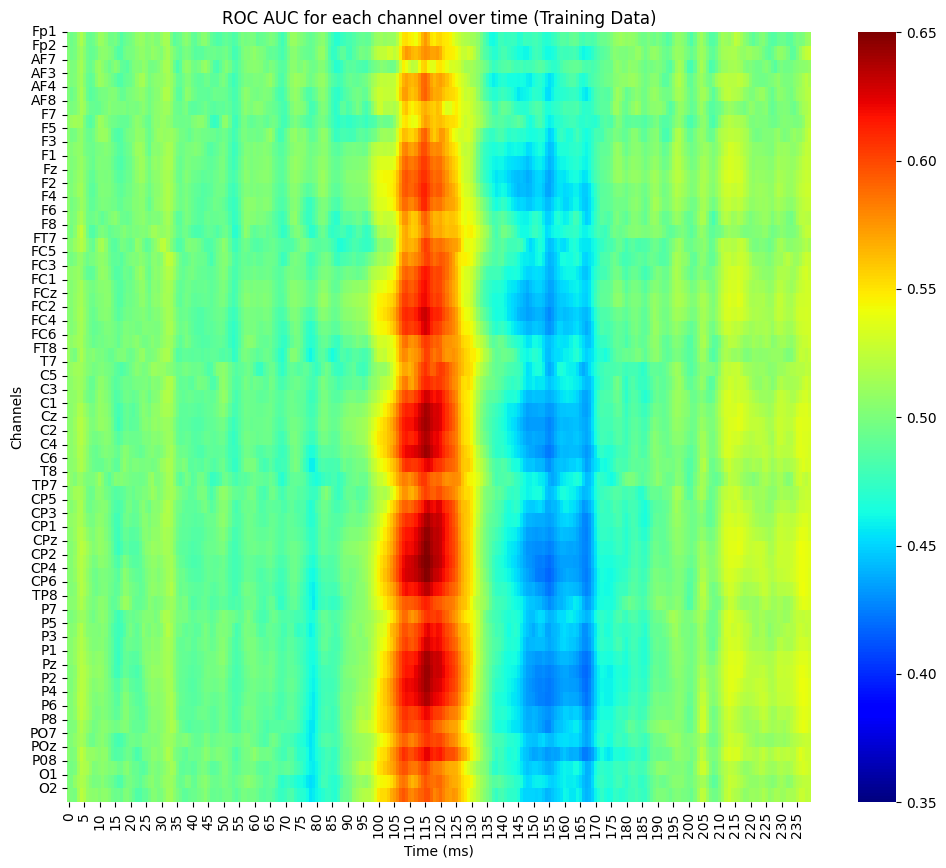

In [12]:
plot_roc(epochs_train, eeg_channels, -200, 1000, 1)

In [53]:
# --------------------------------------------
# 1. Load EEG Channel Locations
# --------------------------------------------
df = pd.read_csv("ChannelsLocation.csv")

# Convert spherical (Radius, Phi) -> Cartesian (X, Y, Z)
df["Phi"] = np.deg2rad(df["Phi"])  # Degrees → Radians
df["X"] = df["Radius"] * np.cos(df["Phi"])
df["Y"] = df["Radius"] * np.sin(df["Phi"])
df["Z"] = np.zeros(len(df))  # Assume 2D electrode layout

# Build Montage
ch_pos = {row["Labels"]: [row["X"], row["Y"], row["Z"]] for _, row in df.iterrows()}
montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# Create MNE Info object
ch_names = list(df["Labels"])
info = mne.create_info(ch_names, sfreq=200, ch_types="eeg")
info.set_montage(montage)

# --------------------------------------------
# 2. Load ROC AUC values
# --------------------------------------------
# Assuming `channel_to_roc` and `eeg_channels` are already defined
arr = np.array([channel_to_roc[channel] for channel in eeg_channels])  # Shape: (n_channels, n_timepoints)

# Time labels: from -200 ms to 1000 ms
n_timepoints = arr.shape[1]
time_labels = np.linspace(-200, 1000, n_timepoints).astype(int)
#time_labels = np.linspace(-200, 1000, 240)


# --------------------------------------------
# 3. Plot in Chunks
# --------------------------------------------
chunk_size = 48
n_chunks = int(np.ceil(n_timepoints / chunk_size))

for chunk in range(n_chunks):
    start = chunk * chunk_size
    end = min((chunk + 1) * chunk_size, n_timepoints)

    f, ax = plt.subplots(6, 8, figsize=(22, 20))
    ax = ax.ravel()

    for i in range(start, end):
        ax_idx = i - start
        ax[ax_idx].set_title(f"{time_labels[i]} ms")
        mne.viz.plot_topomap(
            arr[:, i], info, size=3, cmap="jet", vlim=(0.35, 0.65),
            show=False, outlines="head", axes=ax[ax_idx], contours=False
        )

    # Hide unused subplots
    for j in range(end - start, 48):
        ax[j].axis("off")

    plt.suptitle(f"ROC AUC Topomaps (Time: {time_labels[start]} to {time_labels[end - 1]} ms)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust space for suptitle
    plt.show()


NameError: name 'channel_to_roc' is not defined

In [32]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 650, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 650, 1)
X_test = build_dataset(epochs_test, eeg_channels, 300, 650, 1)

100%|██████████| 56/56 [00:00<00:00, 442.32it/s]


In [33]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5728
    LDA: 0.5773
    RLDA: 0.6220
    Logistic: 0.6184

Applying PCA (0.95 variance, 81 components)
    NCC: 0.5754
    LDA: 0.6076
    RLDA: 0.6008
    Logistic: 0.5977

Applying PCA (0.99 variance, 404 components)
    NCC: 0.5728
    LDA: 0.6208
    RLDA: 0.6240
    Logistic: 0.6145

Applying PCA (1 variance, 3920 components)
    NCC: 0.5728
    LDA: 0.5359
    RLDA: 0.5660
    Logistic: 0.6184



/home/alim/projects/bciproj/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5728
    LDA: 0.5773
    RLDA: 0.6098

Applying PCA (0.95 variance, 81 components)
    NCC: 0.5754
    LDA: 0.6076
    RLDA: 0.5434

Applying PCA (0.99 variance, 404 components)
    NCC: 0.5728
    LDA: 0.6208
    RLDA: 0.6113

Applying PCA (1 variance, 3920 components)
    NCC: 0.5728
    LDA: 0.5359
    RLDA: 0.5620



# Windowed Interval

In [30]:
features = [f"{channel} voltage at {time_point} ms"
            for channel in eeg_channels for time_point in range(300, 450, 5)]

X_train = build_dataset(epochs_train, eeg_channels, 300, 650, 5)
X_test = build_dataset(epochs_test, eeg_channels, 300, 650, 5)

100%|██████████| 56/56 [00:00<00:00, 458.86it/s]


In [31]:
loop(X_train, X_test, y_train, y_test)

No PCA applied
    NCC: 0.5774
    LDA: 0.6268
    RLDA: 0.6181
    Logistic: 0.6307

Applying PCA (0.95 variance, 31 components)
    NCC: 0.5774
    LDA: 0.5683
    RLDA: 0.5701
    Logistic: 0.5679

Applying PCA (0.99 variance, 136 components)
    NCC: 0.5774
    LDA: 0.6146
    RLDA: 0.6155
    Logistic: 0.6137

Applying PCA (1 variance, 784 components)
    NCC: 0.5774
    LDA: 0.6268
    RLDA: 0.6302
    Logistic: 0.6300

